# Plotting the delivery areas
Using Geopandas 
Using shape file from: https://public.opendatasoft.com/explore/dataset/georef-netherlands-postcode-pc4/table/?refine.prov_name=Groningen&refine.gem_name=Groningen&location=10,53.21082,6.61855&basemap=jawg.light 

In [1]:
import pandas as pd
import geopandas as geopandas
import matplotlib.pyplot as plt
import numpy
import folium
from shapely.geometry import Point
import branca

In [2]:
shp_zip_codes = geopandas.read_file("GEO-data/georef-netherlands-postcode-pc4.shp")[["pc4_code", "geometry"]]
#rename column
shp_zip_codes.columns = ["Postcode", "geometry"]
df_dabba = pd.read_excel("Dabba.xlsx", names = ["Klanteigenaar", "Aantal", "Adres", "Postcode", "Datum bezorgd"], usecols="B,F,G,H,O") 
# change the 6 postal code to the first 4 numberecal codes
df_dabba["Postcode"] = df_dabba["Postcode"].apply(lambda x:x[:4])

# count the amount of unqiue postalcodes
df_dabba['Deliveries'] = df_dabba['Postcode'].map(df_dabba['Postcode'].value_counts())

In [9]:
shp_zip_codes["Postcode"].count()

48

In [3]:
# Filter all the postalcodes in the geoframe based on the postalcodes in the dabba dataframe
shp_zip_codes_sorted_dabba = shp_zip_codes[shp_zip_codes["Postcode"].isin(df_dabba["Postcode"].unique())]
# create area in km2 column
shp_zip_codes_sorted_dabba["Area (km2)"] = shp_zip_codes_sorted_dabba['geometry'].to_crs({'init': 'epsg:23095'}).map(lambda p: p.area / 10**6)

c:\Users\tobia\miniconda3\envs\lastmile\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\tobia\miniconda3\envs\lastmile\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [5]:
shp_zip_codes_sorted_dabba.explore()

In [11]:
# merge dabba dataframe with the geoframe
merge = pd.merge(df_dabba[["Datum bezorgd", "Postcode", "Deliveries"]], shp_zip_codes_sorted_dabba, on="Postcode").drop_duplicates()

# #get the number of operational workdays 
working_days = len(merge["Datum bezorgd"].unique())
# calculate the route length approximation per entry
k = 0.92
n = merge["Deliveries"] / working_days # take the total of all deliveries within an postalcode area and devided it by the amount of workingdays
A = merge["Area (km2)"]
# the amount of cyclist needed all deliveries within an postcode area per working day
merge["Number of cyclists"] = numpy.ceil(merge["Deliveries"]/30)
m = numpy.ceil(merge["Number of cyclists"] / working_days)
# Calculate and add Beardwood as new column in km
merge["Beardwood approx"] = k * m * numpy.sqrt((n * A))
# merge[["Postcode", "Area (km2)", "Deliveries", "Beardwood approx"]].sort_values(by="Postcode").to_excel(
#     "Postcode_area_deliveries.xlsx", header=["Postcode gebied (p)", "A", "N", "Beardwood zonder depots"]
#     )

# Results 
Now we have an dataframe including the Beardwood approximation per postalcode based on Dabba information system. We can plot the following maps.
1. general results map based on Postalcode
2. specific on map based on Beardwood's approximation without the D variable

In [12]:
# create a new geoframe based on the merge
results = geopandas.GeoDataFrame(merge[["Postcode", "Deliveries", "Area (km2)", "Number of cyclists", "Beardwood approx"]], geometry=merge["geometry"]).drop_duplicates()
# A CRS tells Python how those coordinates relate to places on the Earth
results.set_crs(epsg=4326, inplace=True)

Postcode  Deliveries  Area (km2)  Number of cyclists  Beardwood approx  \
0         9726         481    0.601153                17.0          2.258043   
481       9731         805    3.213630                27.0          6.754031   
1286      9711        1531    0.816660                52.0          9.390862   
2817      9724         470    0.414576                16.0          1.853609   
3287      9717         629    0.610933                21.0          2.603091   
3916      9741         529    1.421719                18.0          3.641681   
4445      9721        1068    2.332253                36.0          6.627362   
5513      9714        1008    0.553375                34.0          3.136225   
6521      9722         942    1.947917                32.0          5.688240   
7463      9723         767   17.026442                26.0         15.174935   
8230      9718        1101    0.849270                37.0          4.060539   
9331      9713        1850    1.926602                62.0         15.855467   
11181     9715         674    0.667059                23.0          2.815655   
11855     9737         468    1.209471                16.0          3.159279   
12323     9712        1795    0.932552                60.0         10.865907   
14118     9742         802    1.197749                27.0          4.115640   
14920     9732         432    1.043544                15.0          2.819451   
15352     9727         597    3.292695                20.0          5.887489   
15949     9743         739    2.794135                25.0          6.034109   
16688     9725         566    0.698648                19.0          2.640612   
17254     9734         326    3.140654                11.0          4.248993   
17580     9728        1093    4.241345                37.0          9.041263   
18673     9716         355    0.564111                12.0          1.879159   
19028     9736         509    0.933512                17.0          2.894583   
19537     9735          38    1.370953                 2.0          0.958452   
19575     9733         198    0.588166                 7.0          1.433012   
19773     9747          40    2.646747                 2.0          1.366323   

                                                geometry  
0      POLYGON ((6.55042 53.21567, 6.55138 53.21556, ...  
481    POLYGON ((6.58247 53.24621, 6.58255 53.24588, ...  
1286   MULTIPOLYGON (((6.57755 53.21959, 6.57763 53.2...  
2817   POLYGON ((6.58308 53.21218, 6.58426 53.21071, ...  
3287   POLYGON ((6.55684 53.23095, 6.55720 53.23084, ...  
3916   POLYGON ((6.55018 53.24591, 6.55725 53.24379, ...  
4445   POLYGON ((6.58124 53.19827, 6.58149 53.19793, ...  
5513   POLYGON ((6.58512 53.23460, 6.58300 53.23360, ...  
6521   POLYGON ((6.58251 53.20771, 6.58289 53.20753, ...  
7463   POLYGON ((6.64596 53.22445, 6.64611 53.22418, ...  
8230   MULTIPOLYGON (((6.53373 53.21600, 6.53366 53.2...  
9331   MULTIPOLYGON (((6.58560 53.23422, 6.58782 53.2...  
11181  POLYGON ((6.56963 53.23961, 6.56985 53.23954, ...  
11855  MULTIPOLYGON (((6.60207 53.24898, 6.60202 53.2...  
12323  POLYGON ((6.56178 53.22725, 6.56178 53.22724, ...  
14118  POLYGON ((6.54277 53.23755, 6.54313 53.23680, ...  
14920  MULTIPOLYGON (((6.63070 53.23928, 6.63096 53.2...  
15352  POLYGON ((6.55994 53.21168, 6.56012 53.21115, ...  
15949  POLYGON ((6.52663 53.23535, 6.52666 53.23535, ...  
16688  POLYGON ((6.57203 53.21186, 6.57234 53.21180, ...  
17254  POLYGON ((6.61896 53.25260, 6.61942 53.25163, ...  
17580  POLYGON ((6.56277 53.20323, 6.56280 53.20308, ...  
18673  POLYGON ((6.56549 53.23591, 6.56517 53.23544, ...  
19028  POLYGON ((6.60713 53.25415, 6.60713 53.25403, ...  
19537  POLYGON ((6.60975 53.24754, 6.61134 53.24572, ...  
19575  POLYGON ((6.62827 53.24288, 6.62849 53.24253, ...  
19773  MULTIPOLYGON (((6.53141 53.23458, 6.53134 53.2...

In [ ]:
results.explore()

In [ ]:
results.explore(
    column="Postcode",
    tooltip=['Postcode', 'Area (km2)', 'Deliveries', "Beardwood approx"],
    popup=True,
    tiles="CartoDB positron", 
    cmap="Set1", 
    name="Amount of deliveries in Groningen per postalcode area"
) 

In [ ]:
results.explore(
    column="Beardwood approx",
    tooltip=['Postcode', 'Area (km2)', 'Deliveries', "Beardwood approx"],
    popup=True,
    tiles="CartoDB positron", 
    cmap="OrRd", 
    name="Beardwood approximation per postalcode area"
) 

# Influence of the depot location 
Now we have plotted the data and calculated the Beardwood approximation for each postalcode area, we want to add an other factor: depot location. Let start by adding an location marker on the current latitude and longitude position of Cycloon called depot 0.

In [6]:
lat_long_groningen = [53.21917, 6.56667] # starting location of the folium map
depots_locations = [Point(6.598278, 53.210898), Point(6.528022935211814, 53.22563730386978), Point(6.574485373877002, 53.246475527023634), Point(6.555842080055761, 53.201872050167395)]

## Calculate D
Now we want to calculate the distance between the marker on the map and the different postal code areas called D. As D is the distance, we want to multiply it by 2 because you cycle from the depot to the delivery area and back. 

In [7]:
i = 0
for depot_location in depots_locations:
    distances = []
    for phane in results.geometry:
        geo_phane = geopandas.GeoSeries(phane)
        geo_phane.set_crs(23095, inplace=True)
        geo_point = geopandas.GeoSeries(depot_location)
        geo_point.set_crs(23095, inplace=True) 
        d = geo_phane.distance(geo_point).values[0] * 100
        distances.append(d)
    distances = numpy.array(distances) # calculate D
    # results["D_depot_{0}".format(i)] = distances
    results["T*_depot_{0}".format(i)] = (2*distances) + results["Beardwood approx"]
    i=i+1

## Calculate the influence of T* based the results with D locations 
Take the min between the T* columns and sum them.  

In [8]:
results["2_depots"] = results[["T*_depot_0", "T*_depot_1"]].min(axis=1)
results["3_depots"] = results[["T*_depot_0", "T*_depot_1", "T*_depot_2"]].min(axis=1)
results["4_depots"] = results[["T*_depot_0", "T*_depot_1", "T*_depot_2", "T*_depot_3"]].min(axis=1)

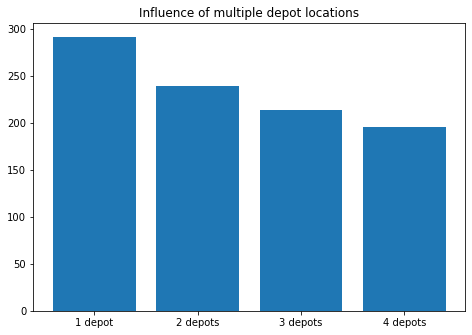

In [29]:
depot_1 = sum(results["T*_depot_0"]) 
depot_2 = sum(results["2_depots"])  
depot_3 = sum(results["3_depots"]) 
depot_4 = sum(results["4_depots"]) 
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
depots = ["1 depot", "2 depots", "3 depots", "4 depots"]
sum_route_length_per_depot = [depot_1, depot_2, depot_3, depot_4]
ax.bar(depots,sum_route_length_per_depot)

plt.title("Influence of multiple depot locations")
plt.show()

# results[[]].plot(kind="bar", figsize=(16, 20), width=0.85) 


## Compare new situation with the current (old) situation in precentage (%)
Compare the old situation of 1 depot with the new situation of multiple depots (2, 3, and 4) by using the following formula:
(new - old) / old * 100 

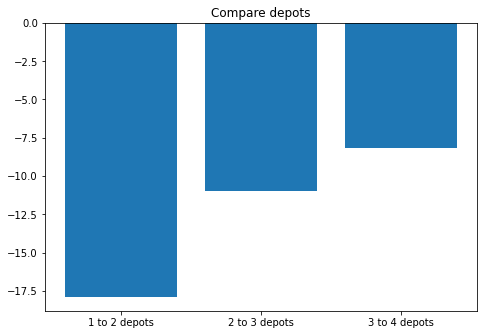

In [30]:
depot_1_to_2 = ((depot_2 - depot_1) / depot_1) * 100
depot_2_to_3 = ((depot_3 - depot_2) / depot_2) * 100
depot_3_to_4 = ((depot_4 - depot_3) / depot_3) * 100

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
depots = ["1 to 2 depots", "2 to 3 depots", "3 to 4 depots"]
new_old = [depot_1_to_2, depot_2_to_3, depot_3_to_4]
ax.bar(depots, new_old)

plt.title("Compare depots")
plt.show()

# Influence on the tour length of depots
Now we visualize the results using folium plotting. 

In [51]:
results

Postcode  Deliveries  Area (km2)  Number of cyclists  Beardwood approx  \
0         9726         481    0.601153                17.0          2.258043   
481       9731         805    3.213630                27.0          6.754031   
1286      9711        1531    0.816660                52.0          9.390862   
2817      9724         470    0.414576                16.0          1.853609   
3287      9717         629    0.610933                21.0          2.603091   
3916      9741         529    1.421719                18.0          3.641681   
4445      9721        1068    2.332253                36.0          6.627362   
5513      9714        1008    0.553375                34.0          3.136225   
6521      9722         942    1.947917                32.0          5.688240   
7463      9723         767   17.026442                26.0         15.174935   
8230      9718        1101    0.849270                37.0          4.060539   
9331      9713        1850    1.926602                62.0         15.855467   
11181     9715         674    0.667059                23.0          2.815655   
11855     9737         468    1.209471                16.0          3.159279   
12323     9712        1795    0.932552                60.0         10.865907   
14118     9742         802    1.197749                27.0          4.115640   
14920     9732         432    1.043544                15.0          2.819451   
15352     9727         597    3.292695                20.0          5.887489   
15949     9743         739    2.794135                25.0          6.034109   
16688     9725         566    0.698648                19.0          2.640612   
17254     9734         326    3.140654                11.0          4.248993   
17580     9728        1093    4.241345                37.0          9.041263   
18673     9716         355    0.564111                12.0          1.879159   
19028     9736         509    0.933512                17.0          2.894583   
19537     9735          38    1.370953                 2.0          0.958452   
19575     9733         198    0.588166                 7.0          1.433012   
19773     9747          40    2.646747                 2.0          1.366323   

                                                geometry  T*_depot_0  \
0      POLYGON ((6.55042 53.21567, 6.55138 53.21556, ...    7.501869   
481    POLYGON ((6.58247 53.24621, 6.58255 53.24588, ...    9.243393   
1286   MULTIPOLYGON (((6.57755 53.21959, 6.57763 53.2...   13.123335   
2817   POLYGON ((6.58308 53.21218, 6.58426 53.21071, ...    4.657015   
3287   POLYGON ((6.55684 53.23095, 6.55720 53.23084, ...   10.870906   
3916   POLYGON ((6.55018 53.24591, 6.55725 53.24379, ...   12.567075   
4445   POLYGON ((6.58124 53.19827, 6.58149 53.19793, ...   10.852443   
5513   POLYGON ((6.58512 53.23460, 6.58300 53.23360, ...    8.556795   
6521   POLYGON ((6.58251 53.20771, 6.58289 53.20753, ...    7.606487   
7463   POLYGON ((6.64596 53.22445, 6.64611 53.22418, ...   15.174935   
8230   MULTIPOLYGON (((6.53373 53.21600, 6.53366 53.2...   11.792269   
9331   MULTIPOLYGON (((6.58560 53.23422, 6.58782 53.2...   18.220918   
11181  POLYGON ((6.56963 53.23961, 6.56985 53.23954, ...    9.243894   
11855  MULTIPOLYGON (((6.60207 53.24898, 6.60202 53.2...    9.587816   
12323  POLYGON ((6.56178 53.22725, 6.56178 53.22724, ...   16.141190   
14118  POLYGON ((6.54277 53.23755, 6.54313 53.23680, ...   14.070416   
14920  MULTIPOLYGON (((6.63070 53.23928, 6.63096 53.2...    7.457533   
15352  POLYGON ((6.55994 53.21168, 6.56012 53.21115, ...   12.530929   
15949  POLYGON ((6.52663 53.23535, 6.52666 53.23535, ...   16.181240   
16688  POLYGON ((6.57203 53.21186, 6.57234 53.21180, ...    6.243926   
17254  POLYGON ((6.61896 53.25260, 6.61942 53.25163, ...    8.520525   
17580  POLYGON ((6.56277 53.20323, 6.56280 53.20308, ...   15.797235   
18673  POLYGON ((6.56549 53.23591, 6.56517 53.23544, ...   10.104974   
19028  POLYGON ((6.60713 53.25415, 6.

In [57]:
#add depot markers to featuregroup
def add_depot_markers_featuregroup(depot_amount, featuregroup): 
    for i in range(len(depots_locations)):
        if i > depot_amount:
            break
        folium.Marker(
                [depots_locations[i].y, depots_locations[i].x], 
                popup="Depot_{0}".format(i+1),
                icon=folium.Icon(color='cadetblue', icon='solid fa-bicycle', prefix='fa')).add_to(featuregroup)

result_map = folium.Map(location=lat_long_groningen, zoom_start=11, tiles=None)

layer_depot_1 = folium.FeatureGroup(name="1 depot", overlay=False).add_to(result_map)
layer_depot_2 = folium.FeatureGroup(name="2 depots", overlay=False).add_to(result_map)
layer_depot_3 = folium.FeatureGroup(name="3 depots", overlay=False).add_to(result_map)
layer_depot_4 = folium.FeatureGroup(name="4 depots", overlay=False).add_to(result_map)

fs=[layer_depot_1, layer_depot_2, layer_depot_3, layer_depot_4]
for i in range(len(fs)):
    add_depot_markers_featuregroup(i, fs[i])
    depot_column_name = ""
    if i == 0:  
        depot_column_name = "T*_depot_{0}".format(i) 
    else: 
        depot_column_name = "{0}_depots".format(i+1)
    
    bins = list(results[depot_column_name].quantile([0, 0.25, 0.5, 0.75, 1]))

    choropleth = folium.Choropleth(
        results, 
        data=results, 
        key_on='feature.properties.Postcode', 
        columns=["Postcode", depot_column_name], 
        fill_color="YlOrRd",
        fill_opacity = 0.8,
        line_opacity = 0,
        line_weight=1,
        bins=bins,
        highlight=True,
        legend_name = "T* per postalcode area based on depot {0}".format(i+1),
        name="T* of {0} depot per Postalcode area".format(i+1)).geojson.add_to(fs[i])

    highlight_function = lambda x: {
        'fillColor': '#ffffff', 
        'color':'#000000', 
        'fillOpacity': 0.1, 
        'weight': 0.1
    }

    folium.GeoJson(data=results, 
        name="tooltip " + depot_column_name,
        tooltip=folium.GeoJsonTooltip(fields=['Postcode', "Deliveries", "Area (km2)", "Number of cyclists", "Beardwood approx", depot_column_name], labels=True, sticky=True),
        style_function=lambda feature: {
            "color": "black",
            "weight": 0.5,
        },
        highlight_function=highlight_function
    ).add_to(choropleth)

min_values = results[["T*_depot_0", "2_depots", "3_depots", "4_depots"]].min()
max_values = results[["T*_depot_0", "2_depots", "3_depots", "4_depots"]].max()
branca.colormap.LinearColormap(
        colors=['#ffffd4', '#fed98e', '#fe9929', '#d95f0e', '#993404'], 
        vmin=min_values.min(), 
        vmax=max_values.max(),
        caption='Routelength per postcode area'
).add_to(result_map)
   
folium.TileLayer(overlay=True, show=True, control=False, name="T* openstreet").add_to(result_map)
folium.TileLayer('cartodbdark_matter',overlay=True, show=False, name="T* dark mode").add_to(result_map)
folium.TileLayer('cartodbpositron',overlay=True, show=False, name="T* light mode").add_to(result_map)
folium.LayerControl(collapsed=False).add_to(result_map)
result_map.save("lastmilegroningen.html")
result_map

### Create map per depot amount

In [77]:
def create_map(map_start_location, depot_locations, results, depot_amount):
    m = folium.Map(location=map_start_location, zoom_start=12, tiles="CartoDB positron")

    for i in range(len(depot_locations)):
        if i > depot_amount:
            break
        folium.Marker(
                [depots_locations[i].y, depots_locations[i].x], 
                popup="Depot_{0}".format(i+1),
                icon=folium.Icon(color='cadetblue', icon='solid fa-bicycle', prefix='fa')).add_to(m)
    
    depot_column_name = ""
    if depot_amount == 0:  
        depot_column_name = "T*_depot_{0}".format(depot_amount) 
    else: 
        depot_column_name = "{0}_depots".format(depot_amount+1)
        
    bins = list(results[depot_column_name].quantile([0, 0.25, 0.5, 0.75, 1]))

    choropleth = folium.Choropleth(
        results, 
        data=results, 
        key_on='feature.properties.Postcode', 
        columns=["Postcode", depot_column_name], 
        fill_color="OrRd",
        fill_opacity = 0.8,
        line_opacity = 1,
        line_weight=1,
        bins=bins,
        legend_name = "T* per postalcode area based on {0}".format(depot_column_name),
        name="T* of {0} per Postalcode area".format(depot_column_name)).add_to(m)

    choropleth.geojson.add_child(
        folium.features.GeoJsonTooltip(fields=['Postcode', "Deliveries", "Area (km2)", "Number of cyclists", "Beardwood approx", depot_column_name], labels=True)
    )
    m.save("{0}depots_groningen.html".format(depot_amount+1))
    folium.LayerControl().add_to(m)
    # return m

## influence on the tour length of 1 depot
At depot 1 at cycloon Groningen

In [78]:
create_map(lat_long_groningen, depots_locations, results, 0)

## influence on the tour length of 2 depots
Depot 1 and 2 at cycloon Groningen and Vinkhuizen

In [79]:
create_map(lat_long_groningen, depots_locations, results, 1)

## Influence of three depots
Depot 1, 2 and 3 at cycloon Groningen, Vinkhuizen and De Hunze

In [80]:
create_map(lat_long_groningen, depots_locations, results, 2)

## Influence of four depots
Depot 1, 2, 3 and 4 at cycloon Groningen, Vinkhuizen, De Hunze and lastly Zuidwest

In [81]:
create_map(lat_long_groningen, depots_locations, results, 3)

In [46]:
excel_export = results.drop_duplicates()
excel_export.sort_values(by="Postcode", inplace=True)
excel_export.to_excel("results_groningen.xlsx")